<a href="https://colab.research.google.com/github/jasondupree/jasondupree.github.io/blob/main/jason_dupree_ml_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook Preparation**

## Import Libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LassoCV, RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, accuracy_score, auc, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Suppress ConvergenceWarning for this context
warnings.simplefilter('ignore', ConvergenceWarning)

## Mount Drive and Update Display

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

pd.set_option('display.max_columns', None)  # Ensures all columns are displayed
pd.set_option('display.width', None)        # Utilizes the maximum width of your display

from IPython.display import display, HTML

Mounted at /content/drive/


## Import Data

In [4]:
file_path = '/content/drive/My Drive/Data Science Courses/Colab Notebooks/Machine Learning/Projects/FINAL/emnist.p'
# Load the data from the pickle file
with open(file_path, 'rb') as file:
    train_images, test_images, train_labels, test_labels = pickle.load(file)

Shape of the first training image: (784,)
Number of input features, n: 784


In [9]:
# Import zeelow.csv
file_path = '/content/drive/My Drive/Data Science Courses/Colab Notebooks/Machine Learning/Projects/FINAL/zeelow.csv'
zeelow_df = pd.read_csv(file_path)

# Import demand.csv
file_path = '/content/drive/My Drive/Data Science Courses/Colab Notebooks/Machine Learning/Projects/FINAL/demand.csv'
demand_df = pd.read_csv(file_path)

# Import doordash.csv
file_path = '/content/drive/My Drive/Data Science Courses/Colab Notebooks/Machine Learning/Projects/FINAL/doordash.csv'
doordash_df = pd.read_csv(file_path)

# 1. Logistic Regression and Decision Trees

## In this problem, you will build models for an online retailer to predict the future demand of its repeat customers. The data, which is given in the file demand.csv, contains information on 1000 customers that made significant purchases in 2019. Imagining that it is December 31st, 2019, your goal will be to predict the variable HighSpend, which identifies customers who were “high” spenders in 2024. (Such binary classification can then be used to drive a targeted marketing campaign.) The other variables encode potentially relevant information about the customers, as described below.

| Variable     | Description |
|--------------|-------------|
| HighSpend    | 1 if the customer was a “high” spender in 2024, 0 if not |
| Spend2019    | Dollars spent by the customer in 2019 |
| Age          | Customer’s age in years (on December 31st, 2019) |
| Cart         | Total dollar value of products added to the virtual shopping cart in 2019 |
| Device       | Primary device used. One of: Mac, PC, Android, iOS |
| Email        | Email account provider. One of: Gmail, Yahoo, Other |
| Income       | Customer’s annual income |
| Payment      | Primary payment method. One of: Debit, Credit, Paypal |
| Premium      | Percentage of purchases in 2019 that were premium products |
| Promotion    | Percentage of purchases in 2019 that were discounted |
| Region       | One of: Northwest, Southwest, Midwest, Northeast, Southeast |
| Sessions     | Number of online shopping sessions in 2019 |
| Time         | Number of minutes spent online shopping in 2019 |
| Clothing     | 1 if one of the purchases in 2019 came from the Clothing category, 0 if not |
| Books        | 1 if one of the purchases in 2019 came from the Books category, 0 if not |
| Electronics  | 1 if one of the purchases in 2019 came from the Electronics category, 0 if not |
| Home         | 1 if one of the purchases in 2019 came from the Home category, 0 if not |
| Garden       | 1 if one of the purchases in 2019 came from the Garden category, 0 if not |
| Pet          | 1 if one of the purchases in 2019 came from the Pet category, 0 if not |
| Grocery      | 1 if one of the purchases in 2019 came from the Grocery category, 0 if not |
| Health       | 1 if one of the purchases in 2019 came from the Health category, 0 if not |
| Outdoors     | 1 if one of the purchases in 2019 came from the Outdoors category, 0 if not |
| Automotive   | 1 if one of the purchases in 2019 came from the Automotive category, 0 if not |
| Beauty       | 1 if one of the purchases in 2019 came from the Beauty category, 0 if not |
| Sports       | 1 if one of the purchases in 2019 came from the Sports category, 0 if not |
| Tools        | 1 if one of the purchases in 2019 came from the Tools category, 0 if not |


## Before proceeding to the questions, perform the following pre-processing steps:
• Apply one-hot encoding to the variables Device, Email, Payment, and Region.

• Divide the data into a training set consisting of the first 700 rows, and a test set
containing the last 300 rows.

In [58]:
# Research
# https://www.kdnuggets.com/2023/07/pandas-onehot-encode-data.html
# https://www.geeksforgeeks.org/how-to-split-a-dataset-into-train-and-test-sets-using-python/

# Encode Categorical Variables
demand_df_encoded = pd.get_dummies(demand_df, columns=['Device', 'Email', 'Payment', 'Region'])

# Split the data into training and testing sets based on the row index
train_df = demand_df_encoded.iloc[:700]
test_df = demand_df_encoded.iloc[700:]

## 1(a): Train an unregularized Logistic Regression model using all of the features. Report your model’s out-of-sample AUC.

In [11]:
# Research
# https://stackoverflow.com/questions/24924755/logit-estimator-in-statsmodels-and-sklearn
# https://benalexkeen.com/scoring-classifier-models-using-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# Define Features and Target Variable
X_train = train_df.drop('HighSpend', axis=1)
y_train = train_df['HighSpend']
X_test = test_df.drop('HighSpend', axis=1)
y_test = test_df['HighSpend']

# Fit the Logistic Regression Model: Use High C Value to Limit Regularization
lr_model = LogisticRegression(C=1e9, solver='liblinear')
lr_model.fit(X_train, y_train)

# Predict Probabilities for the Test Set
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Out-of-sample AUC: {auc}")

Out-of-sample AUC: 0.7397584033613445


## 1(b): Calculate
Predicted Odds of Customer X being a High Spender in 2024
/
Predicted Odds of Customer Y being a High Spender in 2024

where X and Y are identical except X had spent 3 fewer hours online shopping
and resides in the Northeast in comparison to Y who resides in the Midwest.

In [63]:
# Initialize Features
feat_X = X_train.mode().iloc[0].copy()
feat_Y = X_train.mode().iloc[0].copy()

# Reducing Time by 180 minutes for Cust X to Address Diff
feat_X['Time'] -= 180

# Seting Features for X and Y
feat_X['Region_Northeast'] = 1
feat_X['Region_Midwest'] = 0
feat_Y['Region_Northeast'] = 0
feat_Y['Region_Midwest'] = 1

# Setting all other Regions to 0
for region in ['Region_Northwest', 'Region_Southeast', 'Region_Southwest']:
    feat_X[region] = 0
    feat_Y[region] = 0

# Converting to Numpy Array
feat_X = feat_X.values.reshape(1, -1)
feat_Y = feat_Y.values.reshape(1, -1)

# Predicting Probabilities via Logistic Regression
prob_X = lr_model.predict_proba(feat_X)[0, 1]
prob_Y = lr_model.predict_proba(feat_Y)[0, 1]

# Calculating Odds
odds_X = prob_X / (1 - prob_X)
odds_Y = prob_Y / (1 - prob_Y)

# Calculate the odds ratio
odds_ratio = odds_X / odds_Y

print(f"Customer X being high spender: {odds_X}")
print(f"Customer Y being high spender: {odds_Y}")
print(f"Odds Ratio of X/Y: {odds_ratio}")

Customer X being high spender: 9.202347543082864
Customer Y being high spender: 3.0084430176533026
Odds Ratio of X/Y: 3.0588405660616558


## 1(c): Now train a Decision Tree with maximum depth 2, with default hyperparameters otherwise. Plot this tree and include the figure in your report.

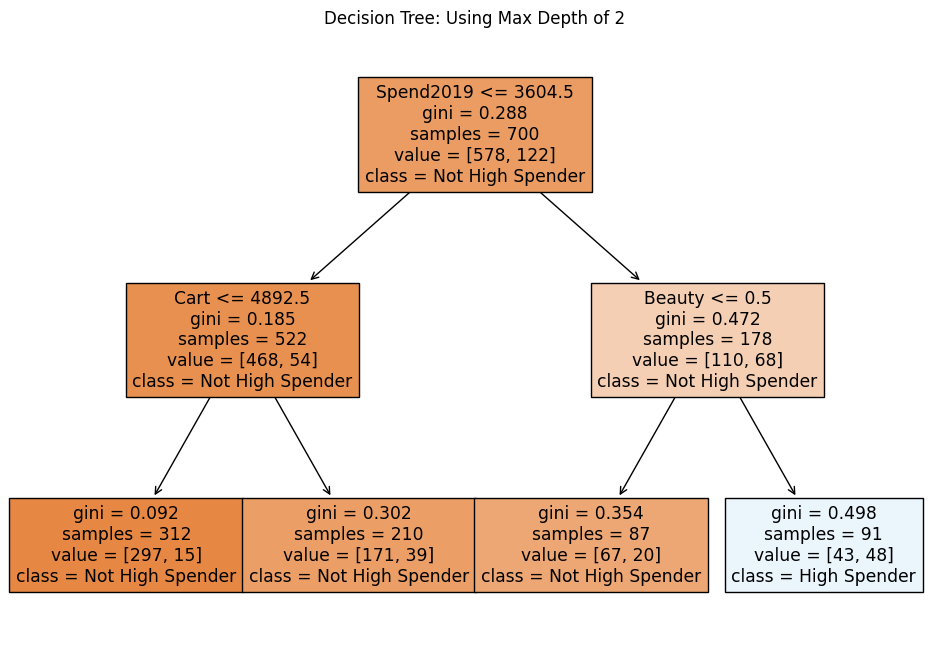

In [69]:
# Research
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# https://www.kdnuggets.com/2019/08/understanding-decision-trees-classification-python.html
# https://www.analyticsvidhya.com/blog/2021/07/a-comprehensive-guide-to-decision-trees/

# Creating and Fitting Decision Tree
dt_model = DecisionTreeClassifier(max_depth=2)
dt_model.fit(X_train, y_train)

# Plotting the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Not High Spender', 'High Spender'])
plt.title("Decision Tree: Using Max Depth of 2")
plt.show()

## 1(d): Describe in detail the type of customer that your decision tree predicts is most likely to be a high spender.

Based on the decision tree you've provided, the customer most likely to be predicted as a high spender in 2024 has the following characteristics:

**Spend2019:** The customer spent more than $3,604.5 in 2019. This is the first split at the root of the tree and indicates that the amount spent in 2019 is a significant predictor of high spending in 2024.

**Beauty:** The customer made at least one purchase in the Beauty category in 2019. After the initial split based on spending, the tree further splits on the 'Beauty' feature. This suggests that among those who spent more than $3,604.5, those who also purchased beauty products are more likely to be high spenders.

The leaf node representing this group shows the highest proportion of high spenders compared to the other leaf nodes, as indicated by the class label being "High Spender" and the Gini impurity being closer to 0.5 compared to other nodes (which implies a higher mix of classes). The exact path in the decision tree for this prediction is:

First, go right at the root node where 'Spend2019' is more than $3,604.5.

Then, go right again at the next node where 'Beauty' purchases exist (greater than 0.5, which likely means at least one purchase was made in that category).

These two criteria combined give us the profile of the customer type the decision tree finds most likely to be a high spender. It's important to note that this decision tree model is relatively simple due to its depth limit and might not capture all the nuances in the data. However, it does provide a straightforward profile for targeting potential high spenders based on past spending behavior and specific product category interest.

## 1(e): Train another Decision Tree, this time using 10-fold cross-validation to select the tuning parameter min samples split (please choose an appropriate range, please use scikit-learn’s default value for max depth). Report your model’s out-of-sample AUC, the optimal value of min samples split thus obtained, and the range of min samples split the search was carried over.

In [76]:
# Research
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/68169640/sklearns-kfold-function-with-shuffle-and-random-state
# https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/
# https://stackoverflow.com/questions/44459845/gridsearchcv-best-score-meaning-when-scoring-set-to-accuracy-and-cv
# https://stackoverflow.com/questions/50232599/interpreting-sklearns-gridsearchcv-best-score
# https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre


# Starting with 2 since trees require at least 2 samples to split a node.
min_samples_split_range = range(2, 51, 2)

# Initialize Parameter Grid
param_grid = {'min_samples_split': min_samples_split_range}

# Initialize Sklearn Classifier
dt_classifier = DecisionTreeClassifier(random_state=0)

# Initialize KFold for Cross-Validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(dt_classifier, param_grid, cv=k_fold, scoring='roc_auc')

# Fit GridSearchCV.
grid_search.fit(X_train, y_train)

# Optimal Out-of-Sample AUC
optimal_auc = grid_search.best_score_

# Optimal Parameter for min_samples_split
optimal_min_samples_split = grid_search.best_params_['min_samples_split']

print(f"Optimal out-of-sample AUC: {optimal_auc}")
print(f"Optimal value of min_samples_split: {optimal_min_samples_split}")
print(f"Range of min_samples_split searched: {min_samples_split_range}")

Optimal out-of-sample AUC: 0.748476697221844
Optimal value of min_samples_split: 44
Range of min_samples_split searched: range(2, 51, 2)


## 1(f): Compute the out-of-sample confusion matrix for your decision tree model from part (e), using a threshold of 0.1 to convert continuous values to binary predictions. Report the True Positive Rate and True Negative Rate.

In [81]:
# Research
# https://stackoverflow.com/questions/57226375/sklearn-logistic-regression-predict-proba-returning-0-or-1
# https://medium.com/@preethi_prakash/mastering-machine-learning-predictions-in-scikit-learn-25e86881a70e
# https://datascience.stackexchange.com/questions/28493/confusion-matrix-get-items-fp-fn-tp-tn-python
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

# Leverage Optimal Model from Grid Search
optimal_dt_model = grid_search.best_estimator_
y_pred_prob = optimal_dt_model.predict_proba(X_test)[:, 1]

# Apply Threshold
threshold = 0.1
y_pred = (y_pred_prob >= threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# True Positive/Negative Rates
TPR = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # TP / (TP + FN)
TNR = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TN / (TN + FP)

print(f"Confusion Matrix:\n{cm}")
print('')
print(f"TPR: {TPR}")
print(f"TNR: {TNR}")

Confusion Matrix:
[[150 122]
 [  8  20]]

TPR: 0.7142857142857143
TNR: 0.5514705882352942


# 2. Clustering and PCA

## Doordash, an online food delivery platform, is seeking to build a model for customer segmentation. To get started, it has extracted a small dataset containing the previous purchases of 800 customers across 2000 restaurants. This data is contained in doordash.csv, where the 800 rows correspond to the customers, the 2000 columns correspond to the restaurants, and the entries represent the total dollars spent by each customer at each restaurant over the past year. Your goal is to cluster the 800 customers according to their purchase patterns.

## 2(a): Cluster the customers using k-Means clustering, taking k to be each value from 1 to 10, and using 10 initializations.1 Plot a scree plot of your results. Repeat this three times (with the exact same code), and include all three plots in your writeup.

**Note that I explicitly chose not to standardize the data because you didn't include it in the instructions - I understand it's a normal practice when using kmeans.**

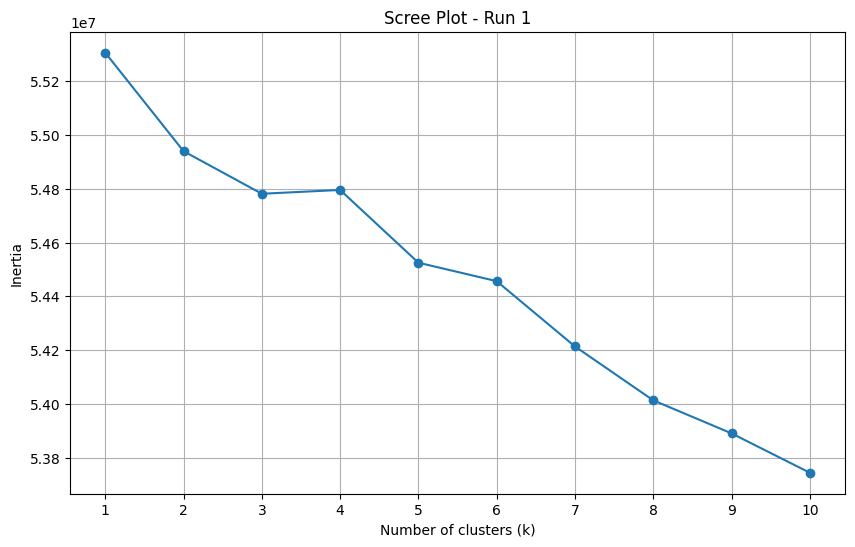

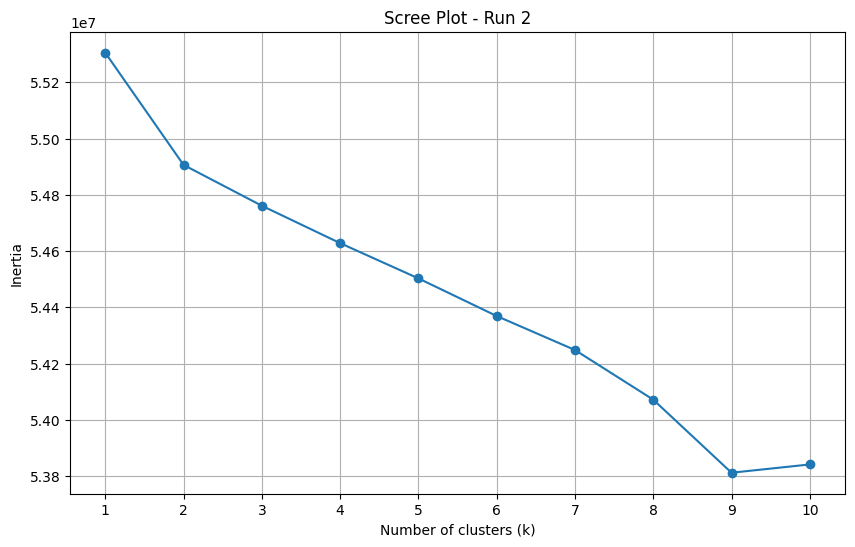

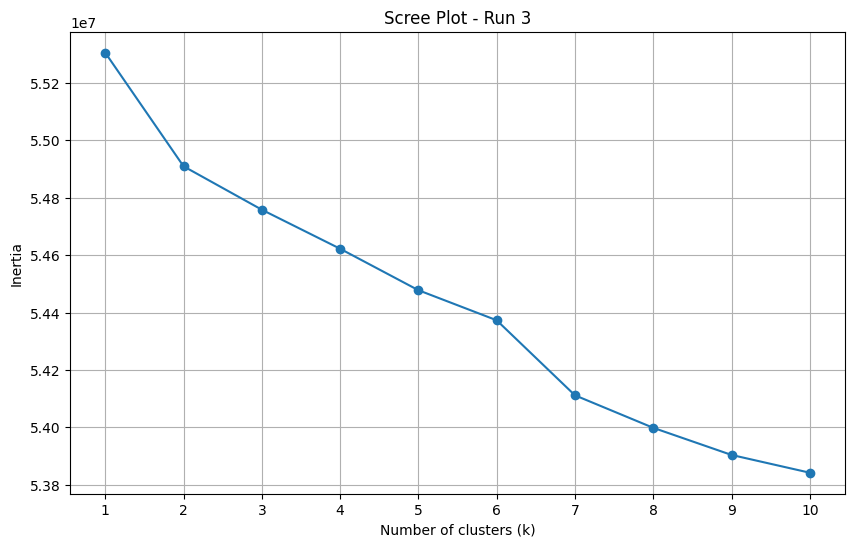

In [92]:
# Research
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://stackoverflow.com/questions/66681127/attributeerror-kmeans-object-has-no-attribute-inertia

# Kmeans + Scree Plot Function
def kmeans_and_scree_plt(data, n_runs=3):
    k_values = range(1, 11)
    for run in range(n_runs):
        inertias = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=run)
            kmeans.fit(data)
            inertias.append(kmeans.inertia_)
        # Plot Figures
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, inertias, marker='o')
        plt.title(f'Scree Plot - Run {run + 1}')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_values)
        plt.grid(True)
        plt.show()

# Execute
kmeans_and_scree_plt(doordash_df)

## 2(b): Are the three scree plots from part (a) identical? If so, explain why this is expected. If not, explain what is causing them to be different?

The slight variations observed in the three scree plots from part (a) are due to the random initialization of centroids in the k-means algorithm. Specifically, the random_state parameter is set to the variable run, which changes with each iteration. Consequently, each run initializes centroids differently, resulting in distinct clustering outcomes across iterations and causing the observed variations in the scree plots.

## 2(c): Perform Principal Component Analysis (PCA) on the data, taking the number of principal components to be 2. (As a sanity check, your transformed data should have 2 columns). Plot the PCA-transformed data as a scatterplot (which is only possible now that there are 2 columns). Include the plot in your writeup.

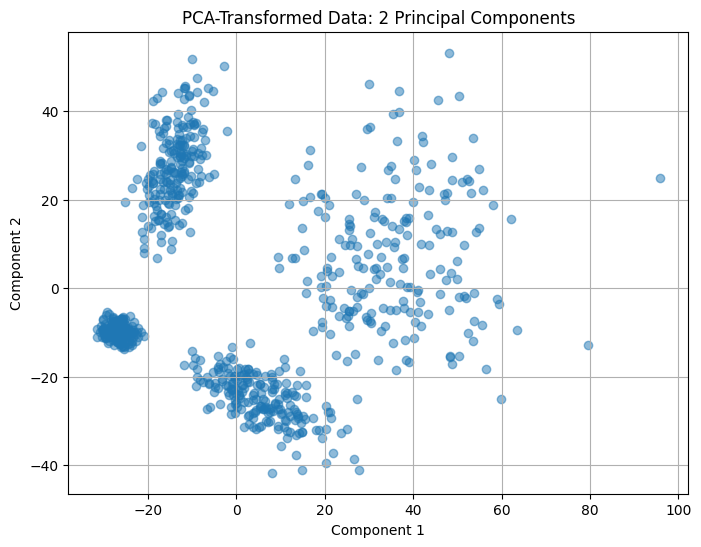

In [93]:
# Research
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html

# Perform PCA (Dimensionality Reduction)
pca = PCA(n_components=2)
doordash_pca = pca.fit_transform(doordash_df)

# Plot PCA Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(doordash_pca[:, 0], doordash_pca[:, 1], alpha=0.5)
plt.title('PCA-Transformed Data: 2 Principal Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

## 2(d): Based on your plot in part (c), what is the “right” number of clusters?

One could argue there are **at least** 3 distinct clusters. I would argue 4 (top right datapoints on the chart), but it's slightly more speculative.

**Final Answer:** Going with **4** distinct clusters.

## 2(e): Repeat part (a), this time using the PCA-transformed data. Do your new scree plots confirm your answer to part (d)?

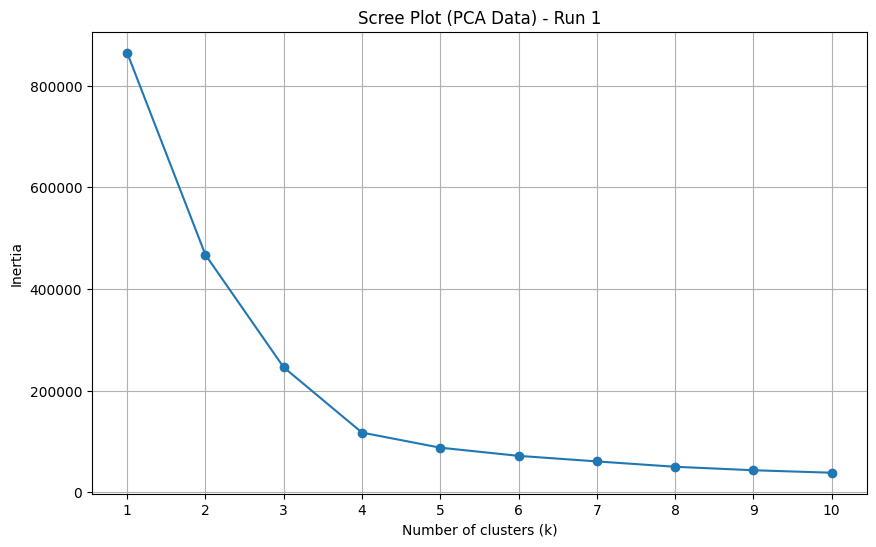

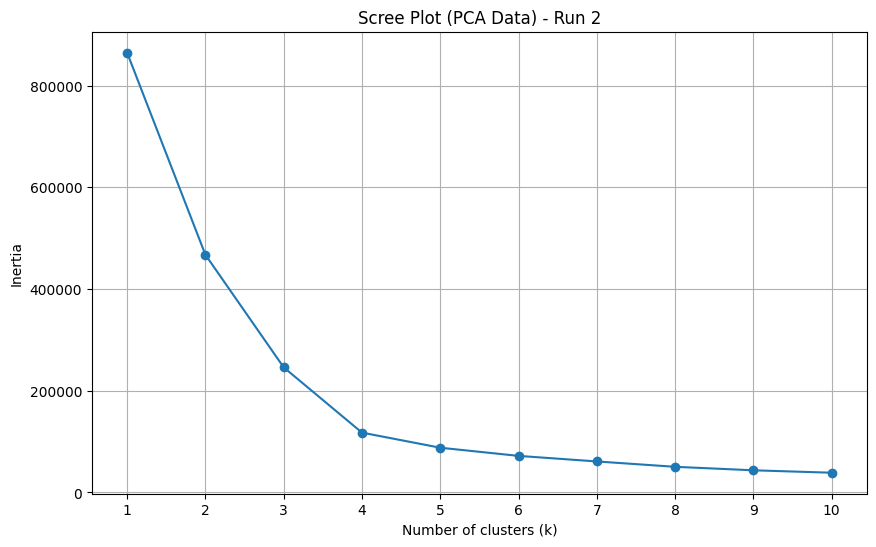

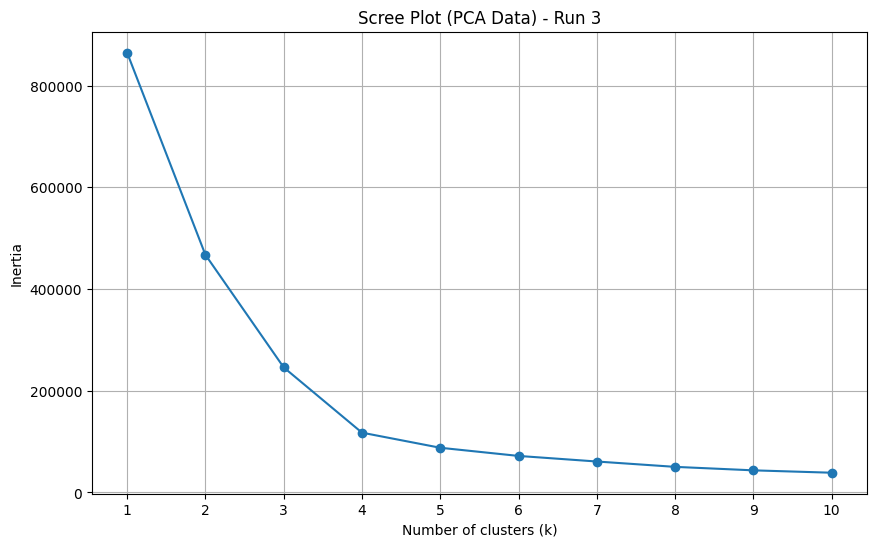

In [94]:
# Research
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://stackoverflow.com/questions/66681127/attributeerror-kmeans-object-has-no-attribute-inertia

# Kmeans + Scree Plot Function for PCA Dataset
def kmeans_and_scree_pca(data, n_runs=3):
    k_values = range(1, 11)
    for run in range(n_runs):
        inertias = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=run)
            kmeans.fit(data)
            inertias.append(kmeans.inertia_)
        # Plot Figures
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, inertias, marker='o')
        plt.title(f'Scree Plot (PCA Data) - Run {run + 1}')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_values)
        plt.grid(True)
        plt.show()

# Execute the function
kmeans_and_scree_pca(doordash_pca)

Yes, the new scree plots support my earlier comment that 4 clusters appears the most reasonable because the charts above show an inflection point ('elbow') at k=4, suggesting using 4 instead of 3 may capture additional structure in the dataset.

## 2(f): Perform k-means clustering on your PCA-transformed data, taking k to be the “right” number of clusters from part (d), and using 100 initializations.Just as in part (c), plot the PCA-transformed data as a scatterplot, but this time color-code the points according to which cluster they belong to. Include the plot in your writeup, and comment on the accuracy of the clustering (a qualitative statement about how close it is to being “perfect” will suffice).

Hint: We saw how to color-code a scatterplot in the clustering notebook.

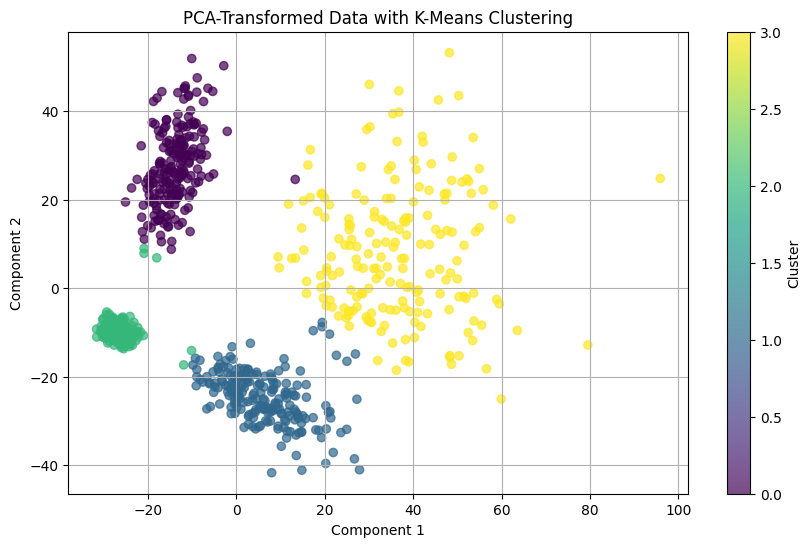

In [95]:
# Research
# https://stackoverflow.com/questions/61966040/cluster-using-different-colours-and-labels
# https://stackoverflow.com/questions/52108558/how-do-parameters-c-and-cmap-behave

# Fit Kmeans to PCA-Transformed Dataset
kmeans = KMeans(n_clusters=4, n_init=100, random_state=42)
cluster_labels = kmeans.fit_predict(doordash_pca)

# Plot the PCA-Transformed Data Using Color-Coded Clusters
plt.figure(figsize=(10, 6))
plt.scatter(doordash_pca[:, 0], doordash_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('PCA-Transformed Data with K-Means Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

It's mostly perfect, but we see four purple nodes that should've been classified as blue and yellow and we see some yellow nodes that should be green. I also see one blue node that should be green.

## 2(g): Perform spectral clustering on the PCA-transformed data, with the same number of clusters from part (d), and taking the similarities to be the nearest neighbors. To tune the number of neighbors, try different numbers of neighbors manually until you find a “perfect” clustering (according to visual inspection of the color-coded scatterplot, as in part (f)). Include your final plot, and the number of neighbors you used.

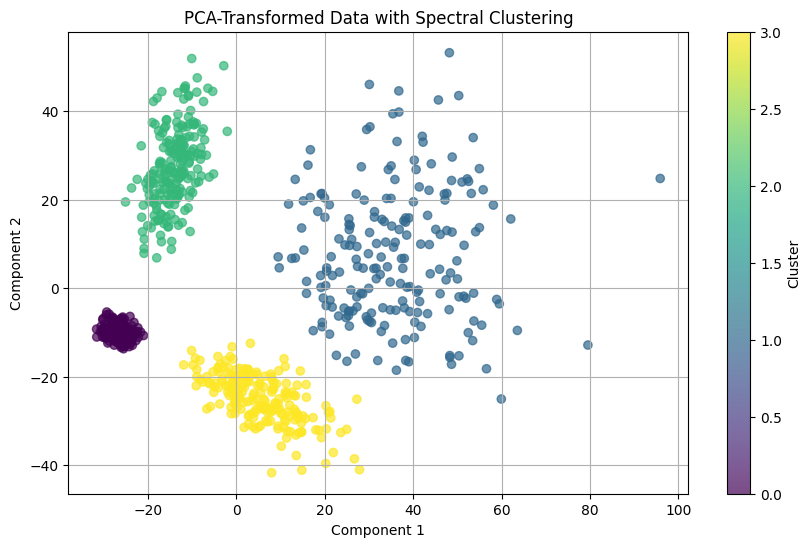

In [102]:
# Research
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
# https://stackoverflow.com/questions/34203358/scikit-learn-spectral-clustering-affinity-with-precomputed
# https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/cluster/_spectral.py

# NN Similarity Matrix
n_neighbors = 11 # Note that 8 initially worked, but when I reran it, 11 was the right number...
nearest_neighbors_graph = kneighbors_graph(doordash_pca, n_neighbors=n_neighbors, mode='connectivity')

# Execute Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=42)
cluster_labels = spectral_clustering.fit_predict(nearest_neighbors_graph)

# Plot the PCA-Transformed Data Using Color-Coded Clusters
plt.figure(figsize=(10, 6))
plt.scatter(doordash_pca[:, 0], doordash_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('PCA-Transformed Data with Spectral Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 3. Skipping the Pink Slip

## Here’s a scenario inspired by ≈ real events. You are a senior data scientist at Zeelow Inc. It’s your first day at work, and you are given a dataset containing house prices (what we want to predict) and square footage of the house (just 1 feature). The dataset is in zeelow.csv. There is no test/train split for this question.

## 3(a): Your boss (who leads Product Strat) wants to “understand” how house prices vary across sizes, and ask you to train a linear regression model with houses prices as the dependent variable. Report the R2 score and the slope term.

In [43]:
# Extracting independent variable (house size) and dependent variable (house price)
X = zeelow_df[['Size']]
y = zeelow_df['Prices']

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Get the R2 score
r2 = r2_score(y, model.predict(X))

# Get the slope term (coefficient)
slope = model.coef_[0]

# Print the R2 score and slope
print("R2 Score:", r2)
print("Slope Term:", slope)

R2 Score: 0.672535415391981
Slope Term: -1.1495219458742423


## 3(b): Hm.. you realize that something’s off. Presenting the finding as is wouldn’t be great for your job security.

You ask around for how the data was collected. You learn that it was aggregated by a survey agency that operates across various countries, which you know could mean that the houses surveyed could be from countries with drastically different per-capita GDP. For example, Country A (which you suspect was surveyed) is largely agrarian, and although the people on average are the least well off there (among all countries in the world), they live in large houses. Country B (which you suspect was also surveyed) is a landlocked country with limited land availablity (with the smallest house sizes in the world), but it is a global financial hub – real estate prices there are quite a bit higher than anywhere else. But in any case, there’s no way to reach out to the survey agency.

Can you figure out which houses are likely to belong to same country? How many countries are represented in the dataset? (When in doubt, choose a smaller number.) Calculate the average price of houses in County B (which is the most well off), average size of houses in Country A (the agrarian one), and the number of houses that you suspect are neither in Country A nor in Country B.

Number of houses in each cluster:
cluster
2    40
1    30
0    30
Name: count, dtype: int64

Number of countries represented in the dataset: 3

Centroids of each cluster:
[[1605.034867   1602.46313485]
 [ 281.17394083 3442.40172122]
 [1053.64204619 2847.96868093]]

Average price of houses in Country B: 1602.4631348490327
Average size of houses in Country A: 281.1739408320305
Number of houses that are neither in Country A nor in Country B: 40



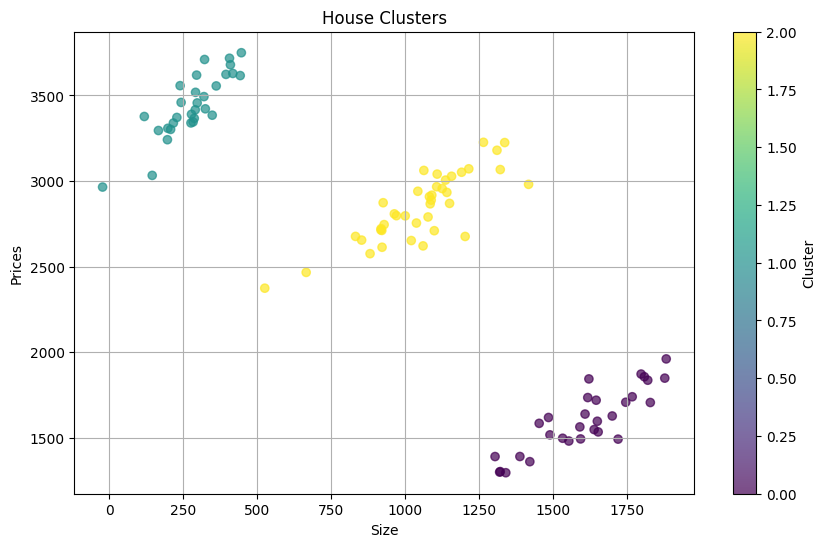

In [56]:
X = zeelow_df[['Size', 'Prices']]

# Fit k-means clustering model
kmeans = KMeans(n_clusters=3, random_state=42)
zeelow_df['cluster'] = kmeans.fit_predict(X)

# Display the counts of houses in each cluster
print("Number of houses in each cluster:")
print(zeelow_df['cluster'].value_counts())

# Display the number of countries (groupings)
num_countries = len(zeelow_df['cluster'].unique())
print("\nNumber of countries represented in the dataset:", num_countries)

# Display the centroids of each cluster
print("\nCentroids of each cluster:")
print(kmeans.cluster_centers_)

# Calculate the average price of houses in Country B
average_price_country_B = np.mean(zeelow_df[zeelow_df['cluster'] == 0]['Prices'])
print("\nAverage price of houses in Country B:", average_price_country_B)

# Calculate the average size of houses in Country A
average_size_country_A = np.mean(zeelow_df[zeelow_df['cluster'] == 1]['Size'])
print("Average size of houses in Country A:", average_size_country_A)

# Calculate the number of houses that are neither in Country A nor in Country B
num_other_houses = len(zeelow_df[zeelow_df['cluster'] == 2])
print("Number of houses that are neither in Country A nor in Country B:", num_other_houses)

print('')

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(zeelow_df['Size'], zeelow_df['Prices'], c=zeelow_df['cluster'], cmap='viridis', alpha=0.7)
plt.title('House Clusters')
plt.xlabel('Size')
plt.ylabel('Prices')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

## 3(c): Assuming you figured out the last part, you breathe a sigh of relief.

Now, you know which houses belong to which country (or technically, at least
which pairs belong in the same). You split your dataset so that all samples in a
partitioned dataset belong to the same country, and run linear regression on each separately.

Report the predicted increase in house prices with each additional unit of area for Country A (agrarian). Same for Country B (finance hub). Also, report the R2
for the regression instance for Country A (agrarian); no need for B.

In [57]:
# Split the dataset into two separate datasets for Country A and Country B
country_A_df = zeelow_df[zeelow_df['cluster'] == 1]
country_B_df = zeelow_df[zeelow_df['cluster'] == 0]

# Perform linear regression separately for each country
from sklearn.linear_model import LinearRegression

# Linear regression for Country A
X_country_A = country_A_df[['Size']]
y_country_A = country_A_df['Prices']

regression_country_A = LinearRegression()
regression_country_A.fit(X_country_A, y_country_A)

# Predicted increase in house prices with each additional unit of area for Country A
slope_country_A = regression_country_A.coef_[0]
print("Predicted increase in house prices with each additional unit of area for Country A:", slope_country_A)

# R2 score for the regression instance for Country A
r2_country_A = regression_country_A.score(X_country_A, y_country_A)
print("R2 score for Country A:", r2_country_A)

Predicted increase in house prices with each additional unit of area for Country A: 1.5359732371089332
R2 score for Country A: 0.732750239918147


## 3(d): Explain in words the source of the discrepancy, or lack of it, between your findings concerning the relationship between price and size in the parts (a) and (c) above. Set aside your ML knowledge, how would you explain it to a layn person?

The discrepancy between the findings in parts (a) and (c) arises from the oversight of country-specific factors in the initial analysis. When considering each country separately in part (c), we observed varying relationships between house size and price, reflecting the unique housing market dynamics and socio-economic factors of each country, such as land availability and lifestyle preferences.

# 4. Neural Networks

## 4(a): The following is a small neural network. Three variables x1, x2, x3 are input, and the letters L, R, and S represent linear, ReLU, and sigmoid nodes, respectively. The output, y, is thus a function of x1, x2, x3. How many rainable parameters does this neural net have?

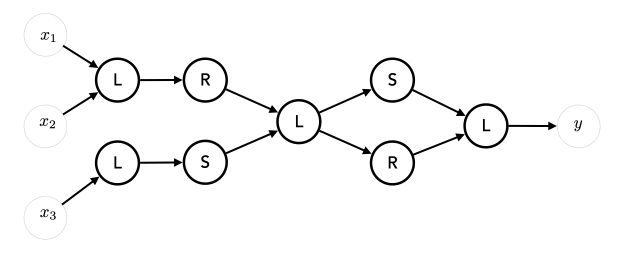

## 4(b): he following is a single convolutional node. It takes a 3-by-2 input
(with each “pixel” denoted separately as variables x1, . . . , x6 here), and applies a 2-by-2 filter. Write the output(s) of this node explicitly as a function of x1, . . . , x6, and make clear which parameters are to be tuned.

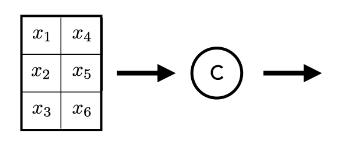

Believe it or not, there is yet another sibling to the famous MNIST dataset. This one is called EMNIST (the “E” stands for Extended), and contains handwritten letters of the alphabet. Tthe images in EMNIST are 28-by-28 pixels in grayscale, there are 60,000 training samples, and there are 10,000 test samples. Here are a few example images from the dataset:

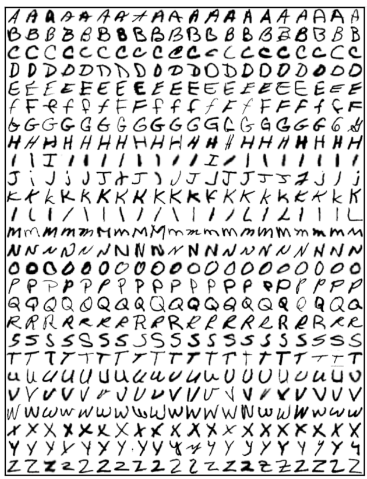

You can load the data by running the following command:

X train,X test,y train,y test = pickle.load(open(‘emnist.p’,‘rb’))

If you inspect y train or y test, you will see that the labels take values between 0 and 25. Logically, 0 corresponds to the letter A, 1 corresponds to the letter B, and so on.

## 4(c): Consider a neural network with the following architecture:

• a linear layer with 256 nodes, followed by

• a ReLU layer, followed by

• a linear layer with 128 nodes, followed by

• a ReLU layer, followed by

• a linear layer with 26 nodes

Train this network until you are sufficiently confident it has converged, and report the out-of-sample accuracy. In your writeup, include screenshots of both the model itself (in code), and your accuracy.

## 4(d): Parameter Questions
How many (trainable) parameters does the network from part (c) have?

Why did we choose (the output dimension of) the last layer to be 26 in width?

## 4(e): Consider a neural network with the following architecture:
• a convolutional layer with 32 nodes, each applying a 5-by-5 filter, followed by

• a ReLU layer, followed by

• a MaxPool layer with 2-by-2 window, followed by

• a convolutional layer with 16 nodes, each applying a 5-by-5 filter, followed by

• a ReLU layer, followed by

• a MaxPool layer with 2-by-2 window, followed by

• a linear layer with 128 nodes, followed by

• a ReLU layer, followed by

• a linear layer with 26 nodes

Train this network until you are sufficiently confident it has converged, and report the out-of-sample accuracy. In your writeup, include screenshots of both the model itself (in code), and your accuracy.

## 4(f): How many (trainable) parameters does each layer in the network from part (e) have?

## 4(g): onsider a neural network with the following architecture:
• a convolutional layer with 32 nodes, each applying a 5-by-5 filter, followed by

• a MaxPool layer with 2-by-2 window, followed by

• a ReLU layer, followed by

• a convolutional layer with 16 nodes, each applying a 5-by-5 filter, followed by

• a MaxPool layer with 2-by-2 window, followed by

• a ReLU layer, followed by

• a linear layer with 128 nodes, followed by

• a ReLU layer, followed by

• a linear layer with 26 nodes

Would you expect this neural net to do better or worse on out-of-sample accuracy
(say) than the neural net trained in part (e)? How would your answer to the
previous question change if ReLUs were replaced with Sigmoids in both neural
nets? Explain your reasoning as precisely as possible. (No actual training/code
needed for this part.)